In [1]:
!pip install kaggle -U

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [2]:
! pip install fastai -U

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.60)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'titanic/'

Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
from pathlib import Path

In [0]:
from fastai import *
from fastai.vision import *
from fastai.tabular import *

In [0]:
path = Path(base_dir)
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [8]:
train = pd.read_csv(f'{path}/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [10]:
test = pd.read_csv(f"{path}/test.csv")
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [0]:
test_id = test['PassengerId'] 

test["Fare"] = test["Fare"].fillna(value =test["Fare"].mean())

In [12]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [0]:
train_title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"] = pd.Series(train_title)

In [0]:
test_title = [i.split(",")[1].split(".")[0].strip() for i in test["Name"]]
test["Title"] = pd.Series(test_title)

In [0]:
train["Family_size"] = train["SibSp"] + train["Parch"] + 1
test["Family_size"] = test["SibSp"] + test["Parch"] + 1

In [16]:
dep_var = 'Survived'
#cat_names = data.select_dtypes(exclude=['int', 'float']).columns
# cat_names = ['Sex','SibSp', 'Pclass', 'Title', 'Parch', 'Family_size']
# cont_names = data.select_dtypes([np.number]).columns
# cont_names = ['Age', 'Fare']

# cont_names, cat_names = cont_cat_split(df=train, max_card=20, dep_var='Survived')
cat_names = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title', 'Family_size'] # 'Embarked','Cabin',
cont_names = ['Age', 'Fare']


print("Categorical columns are : ", cat_names)
print('Continuous numerical columns are :', cont_names)
procs = [FillMissing, Categorify, Normalize]

Categorical columns are :  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title', 'Family_size']
Continuous numerical columns are : ['Age', 'Fare']


In [0]:
test = TabularList.from_df(test, cat_names=cat_names, cont_names=cont_names)

In [18]:
data = (TabularList.from_df(train, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .random_split_by_pct(valid_pct=0.2, seed=43)
                        .label_from_df(cols = dep_var)
                        .add_test(test, label=0)
                        .databunch())

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [19]:
data.show_batch(rows=10)

Pclass,Sex,SibSp,Parch,Title,Family_size,Age_na,Age,Fare,target
2,female,0,0,Miss,1,True,-0.0712,-0.4012,1
2,female,1,0,Mrs,2,False,-0.0712,-0.1391,1
1,female,2,2,Miss,5,False,-0.9098,4.4006,1
3,male,4,1,Master,6,False,-1.7484,0.1238,0
3,female,2,0,Miss,3,True,-0.0712,-0.1919,1
3,female,0,0,Miss,1,True,-0.0712,-0.4821,0
2,female,1,0,Mrs,2,False,-0.4524,-0.1391,1
3,male,0,0,Mr,1,False,-0.8336,-0.4891,0
3,female,0,0,Miss,1,False,0.0431,-0.4896,0
3,male,0,0,Mr,1,False,-0.7573,-0.4862,0


In [0]:
learn = tabular_learner(data, layers=[1000, 200, 15], metrics=accuracy, emb_drop=0.1,)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


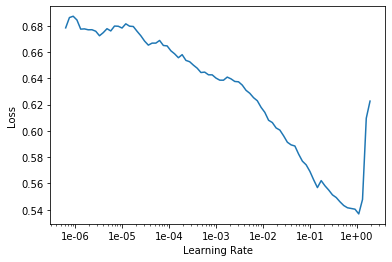

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(15, max_lr=slice(1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.633380,0.678699,0.679775,00:00
1,0.587938,0.640301,0.696629,00:00
2,0.541057,0.570304,0.724719,00:00
3,0.502583,0.545847,0.741573,00:00
4,0.472834,0.512018,0.786517,00:00
5,0.449971,0.575644,0.786517,00:00
6,0.428917,0.495057,0.792135,00:00
7,0.411612,0.545870,0.786517,00:00
8,0.396096,0.519809,0.803371,00:00
9,0.383909,0.520300,0.808989,00:00


In [23]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(8, 5)
    (3): Embedding(8, 5)
    (4): Embedding(17, 8)
    (5): Embedding(10, 6)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1000, out_features=200, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=15, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=15, out_features=2, bias=True)
  )
)

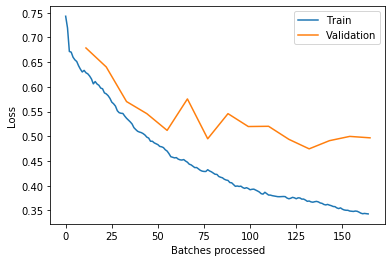

In [24]:
learn.recorder.plot_losses()

In [25]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [26]:
submission = pd.DataFrame({'PassengerId': test_id, 'Survived': labels})
submission.to_csv('submission.csv', index=False)
submission.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [29]:
learn.show_results()

Pclass,Sex,SibSp,Parch,Title,Family_size,Age_na,Age,Fare,target,prediction
3,male,0,0,Mr,1,False,-0.4524,-0.4560,0,0
1,female,0,1,Miss,2,False,-1.0623,0.1183,1,1
2,male,0,0,Mr,1,False,-0.9098,-0.4176,0,0
3,female,0,0,Miss,1,False,-0.6049,-0.4896,1,1
3,male,4,2,Master,7,False,-2.0533,-0.0356,1,0
